In [1]:
from xgboost import XGBClassifier
import shap
import numpy
import numpy as np
from numpy import mean, std
import xgboost
from xgboost import XGBClassifier
import seaborn as sns
import scipy
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import recall_score,average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import ConnectionPatch
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import  roc_curve, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df=pd.read_csv('data/df.csv',index_col=0)

In [3]:
X=df.iloc[:,:-1]
y=[]
for i in df.index:
    if df.loc[i,'Diagnosis']=='Normal':
        y.append(0)
    else:
        y.append(1)
y=np.array(y)

In [4]:
np.random.seed(1) # Reproducibility 
CV_repeats = 20
# Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
random_states = np.random.randint(10000, size=CV_repeats) 

######## Use a dict to track the SHAP values of each observation per CV repitition 

shap_values_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    shap_values_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}
        



------------ CV Repeat number: 0

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 1

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 2

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 3

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 4

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 5

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------------ CV Repeat number: 6

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

--

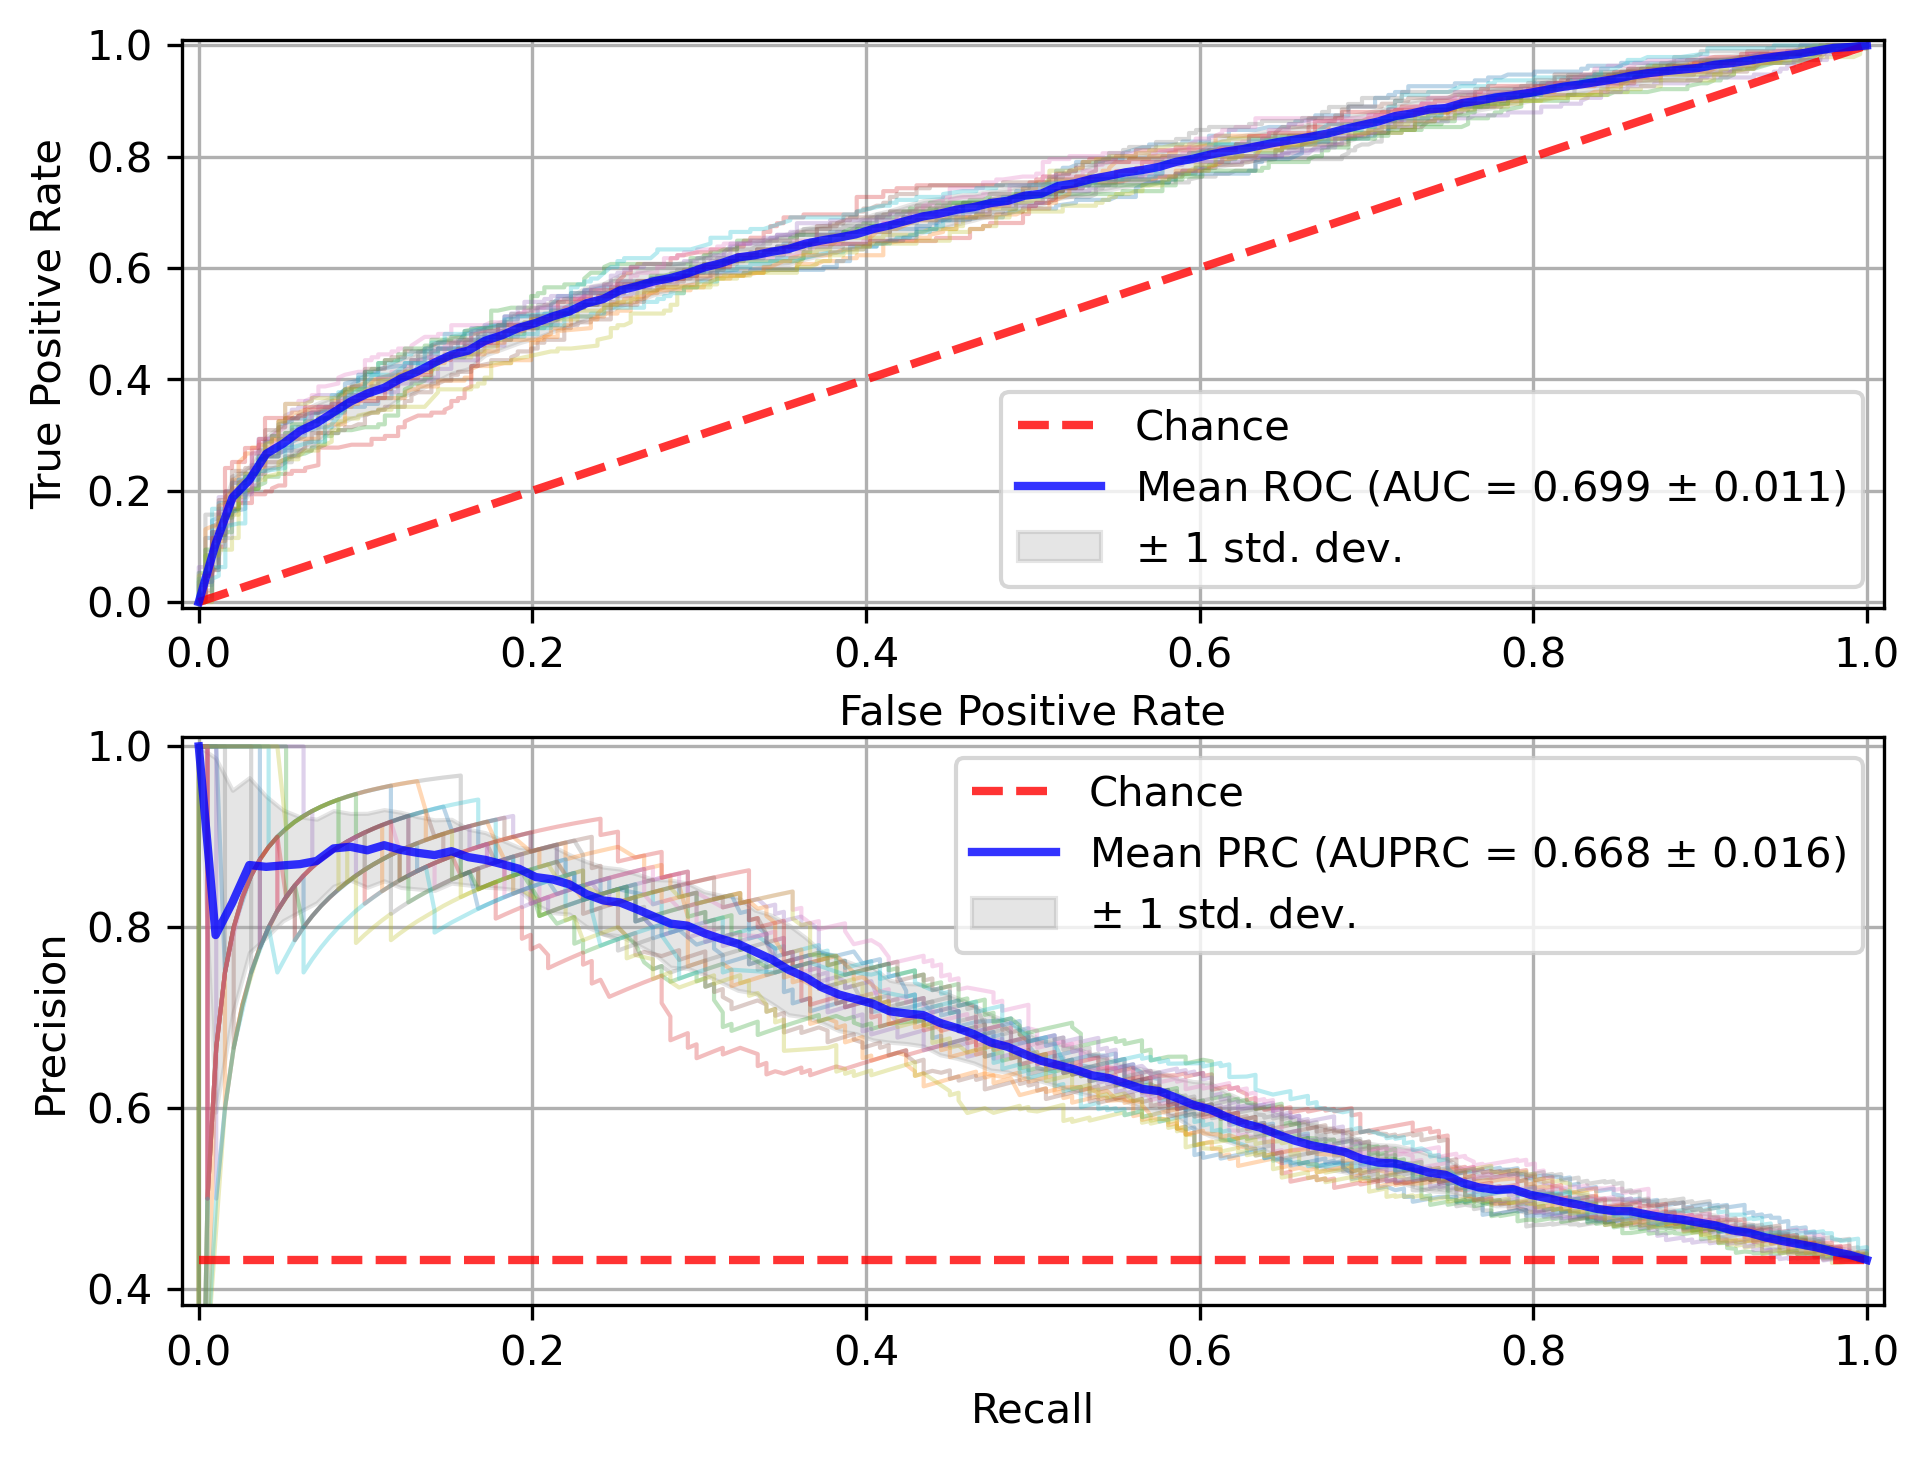

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, dpi=300#,figsize=(15, 15)
                      )
fig.tight_layout()
ax1, ax2 = ax.flatten()
param_grid = [{'max_depth': [None,3,5],
               'n_estimators': np.arange(50,300,50)
              }]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precision_array = []
mean_recall_array = np.linspace(0, 1, 100)
aucs_pr=[]

importance_rf=pd.DataFrame(columns=X.columns)

acc_rf=list()
prec_rf=list()
f1_rf=list()


for i, CV_repeat in enumerate(range(CV_repeats)): #-#-#
    #Verbose 
    print('\n------------ CV Repeat number:', CV_repeat)
    #Establish CV scheme
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_states[i]) # Set random state 

    ix_training, ix_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X,y):
        ix_training.append(fold[0]), ix_test.append(fold[1])
    
    predicted=[]
    label=[]
    score=[]
    
    ## Loop through each outer fold and extract SHAP values 
    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
        #Verbose
        print('\n------ Fold Number:',i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        index_train, index_test=X_train.index, X_test.index
        y_train, y_test = y[train_outer_ix], y[test_outer_ix]

        
        #simple imputer
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp_mean.fit(X_train)
        X_train=imp_mean.transform(X_train)
        X_test=imp_mean.transform(X_test)

        
        ## Establish inner CV for parameter optimization #-#-#
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) #-#-#
        
        # Search to optimize hyperparameters
        model =RandomForestClassifier(random_state=0)
        search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv=cv_inner, refit=True,random_state=0) #-#-#
        result = search.fit(X_train, y_train) #-#=#
        
        best_model=result.best_estimator_
        # Fit model on training data 
        best_model.fit(X_train, y_train) #-#-#
        
        
        yhat = best_model.predict(X_test)
        
        y_score = best_model.predict_proba(X_test)[:, 1]
        
        label.append(y_test)
        
        predicted.append(yhat)
        score.append(y_score)
        
       

        coef=pd.DataFrame(best_model.feature_importances_.reshape(1,-1),columns=X.columns)
       
        importance_rf=pd.concat([importance_rf,coef],ignore_index=True)
        
        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(best_model, data=X_train, feature_perturbation='interventional')
        shap_values = explainer.shap_values(X_test)[1]

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(X.index[test_outer_ix]):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
            
    acc_sc=accuracy_score(np.hstack(label), np.hstack(predicted))
    acc_rf.append(acc_sc)
    #print('Accuracy:',round(acc,4))

    prec_sc=precision_score(np.hstack(label), np.hstack(predicted),pos_label=1)
    prec_rf.append(prec_sc)
    #print('Precision:',round(prec,4))

    
    f1_sc=f1_score(np.hstack(label), np.hstack(predicted))
    f1_rf.append(f1_sc)
    
    #ROC
    fpr, tpr, threshold= roc_curve(np.hstack(label), np.hstack(score))
    tprs.append(np.interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=metrics.auc(fpr,tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, lw=1, alpha=0.3)
    
    #PR
    precision_fold, recall_fold, _ = precision_recall_curve(np.hstack(label), np.hstack(score))
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]  # reverse order of results
    prec_array = np.interp(mean_recall_array, recall_fold, precision_fold)
    precision_array.append(prec_array)
    precision_array[-1][0]=1
    pr_auc = metrics.auc(recall_fold, precision_fold)
    aucs_pr.append(pr_auc)
    
    ax2.plot(recall_fold, precision_fold, alpha=0.3, lw=1)
    
            

ax1.plot([0,1], [0,1], linestyle='--', lw=2,color='r', label='Chance',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_xlabel('False Positive Rate'#,fontsize=20
              )
ax1.set_ylabel('True Positive Rate'#,fontsize=20
              )
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.title('Repeated Cross-Validation ROC',fontsize=18)
ax1.legend(loc="lower right"
           #,bbox_to_anchor=(1.65, 0.01)
           #, prop={'size': 22}
          )

ax1.grid()

# plot the precision-recall curves
no_skill = len((np.hstack(label))[(np.hstack(label))==1]) / len((np.hstack(label)))
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--',lw=2, label='Chance',alpha=0.8,color='r')
mean_precision_array=np.mean(precision_array, axis=0)
#mean_precision_array[-1]=1.0
mean_auc_pr=metrics.auc(mean_recall_array,mean_precision_array)
std_auc_pr=np.std(aucs_pr)
ax2.plot(mean_recall_array,mean_precision_array, color='b',
         label=r'Mean PRC (AUPRC = %0.3f $\pm$ %0.3f)' %(mean_auc_pr, std_auc_pr),
         lw=2,alpha=0.8)

std_precision_array=np.std(precision_array, axis=0)
precision_array_upper=np.minimum(mean_precision_array+std_precision_array,1)
precision_array_lower=np.maximum(mean_precision_array-std_precision_array,0)
ax2.fill_between(mean_recall_array,precision_array_lower,precision_array_upper,color='grey',
         alpha=0.2,label=r'$\pm$ 1 std. dev. ')

ax2.set_xlim([-0.01,1.01])
ax2.set_ylim([no_skill-0.05,1.01])
ax2.set_xlabel('Recall'#, fontsize=18
              )
ax2.set_ylabel('Precision'#,fontsize=18
              )
#ax2.set_xticks([18])
#ax2.set_yticks([18])

ax2.legend(loc='upper right')

ax2.grid()

plt.show()    

In [6]:
print('ACC: %.3f (%.3f)' % (mean(acc_rf), std(acc_rf)))
print('Precision: %.3f (%.3f)' % (mean(prec_rf), std(prec_rf)))
print('AuROC: %.3f (%.3f)' % (mean_auc, std_auc))
print('AuPRC: %.3f (%.3f)' % (mean_auc_pr, std_auc_pr))
print('F1: %.3f (%.3f)' % (mean(f1_rf), std(f1_rf))) 

ACC: 0.673 (0.015)
Precision: 0.729 (0.038)
AuROC: 0.699 (0.011)
AuPRC: 0.668 (0.016)
F1: 0.507 (0.030)


In [7]:
# Melted data i.e., long format
df_importance_rf = pd.melt(importance_rf,var_name='feature name', value_name='coef. of importance')
grouped_rf= df_importance_rf.loc[:,['feature name', 'coef. of importance']] \
    .groupby(['feature name']) \
    .median() \
    .sort_values(by='coef. of importance',ascending=False)

Text(0, 0.5, 'Feature')

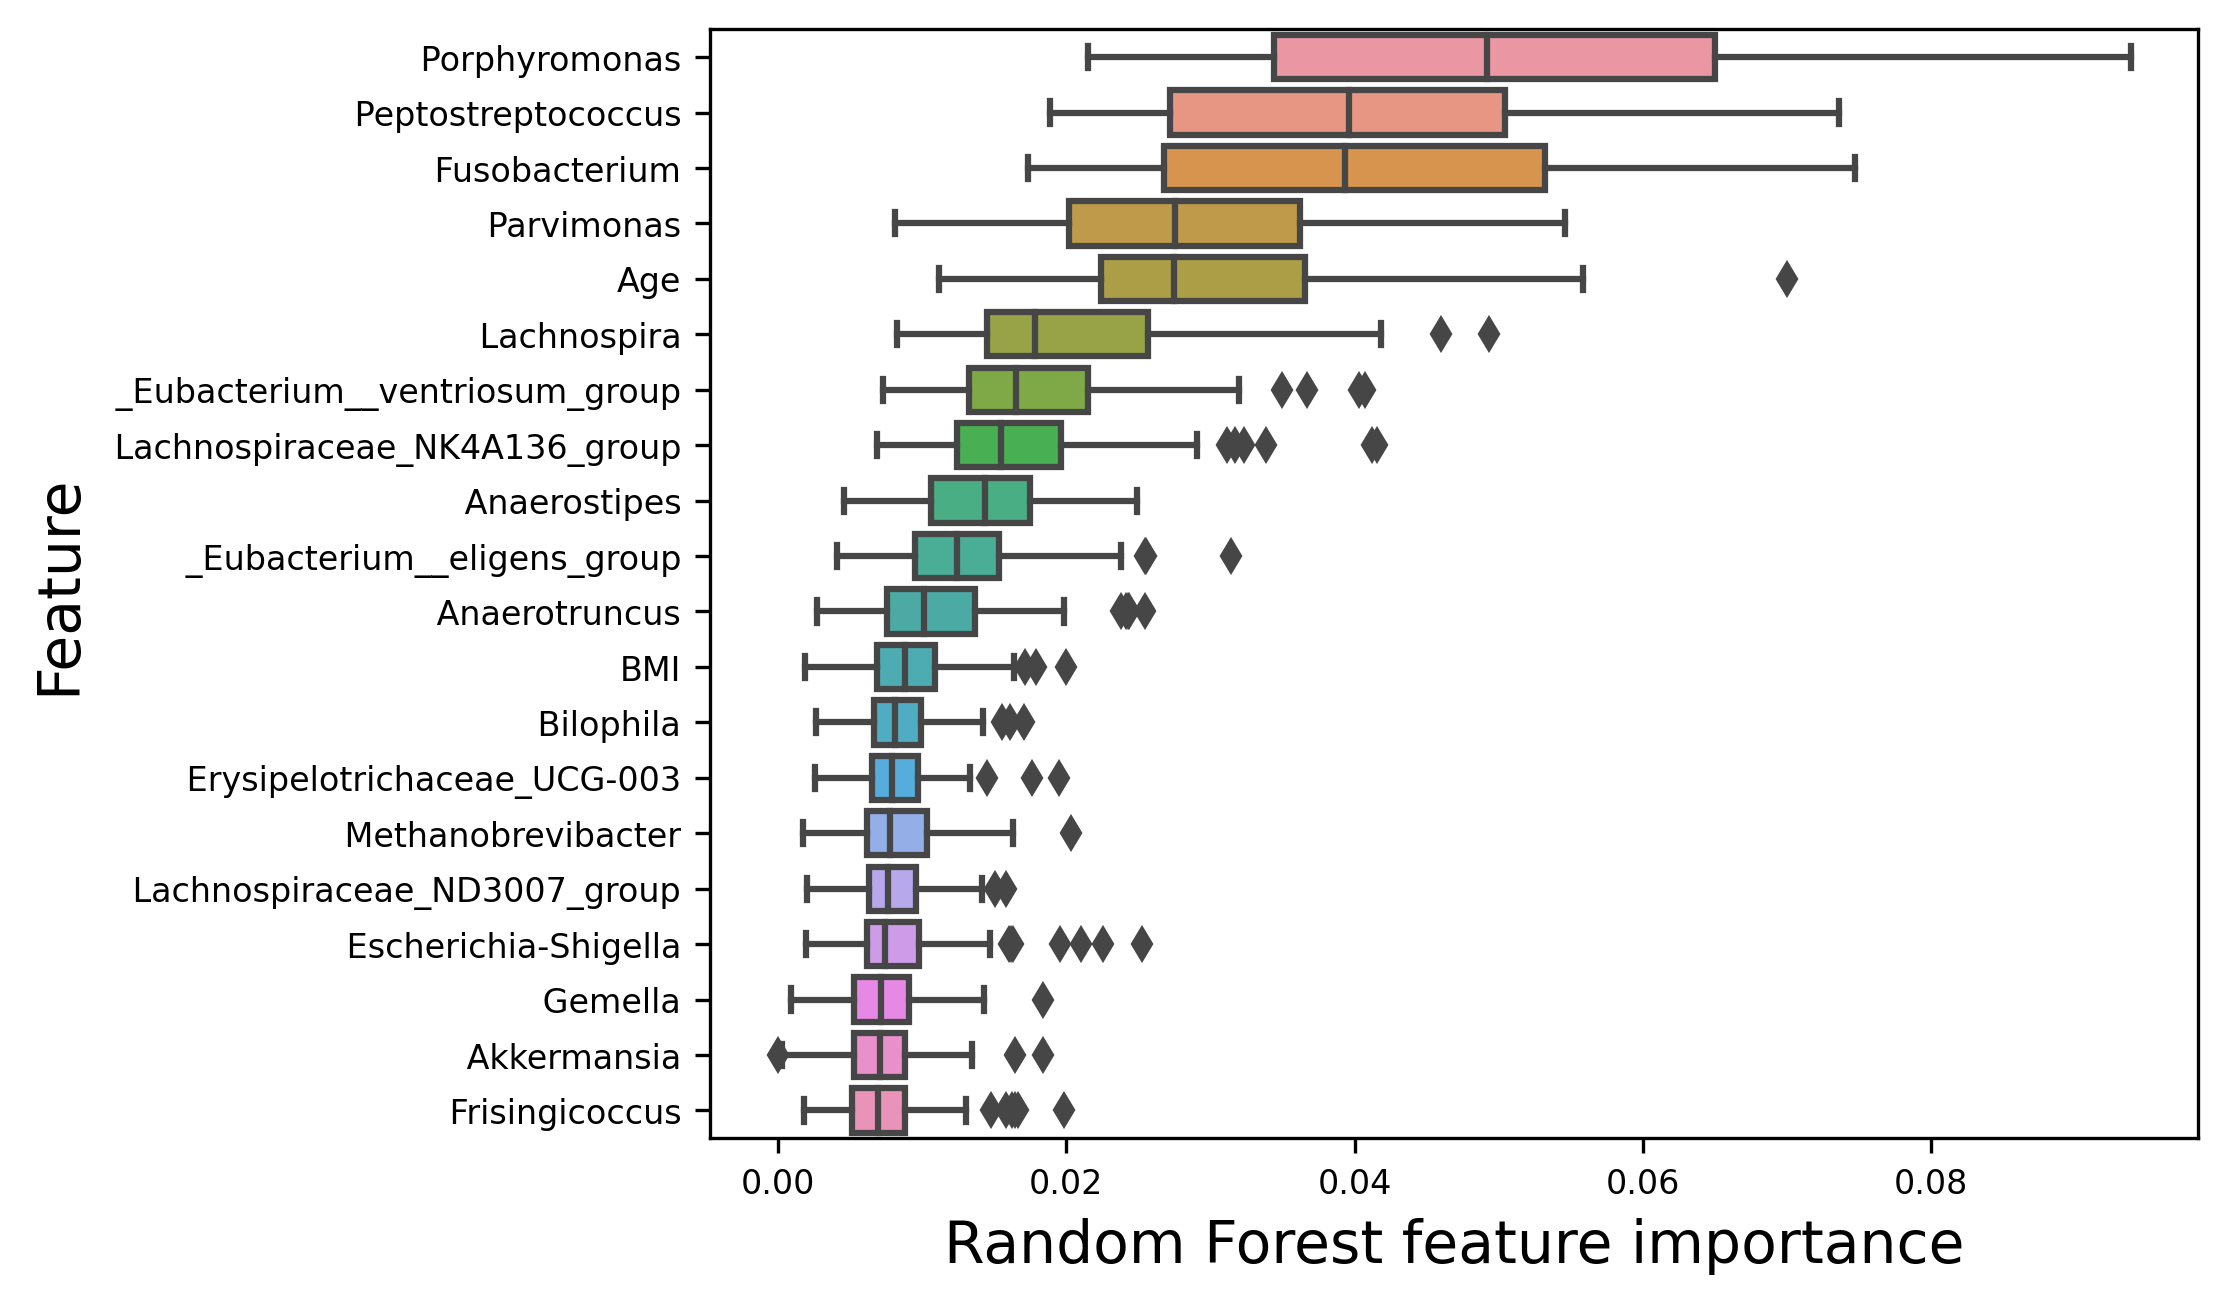

In [8]:
plt.figure(dpi=300)
sns.boxplot(y="feature name", x="coef. of importance", data=df_importance_rf,order=grouped_rf.index[:20])


plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Random Forest feature importance',fontsize=14)
plt.ylabel('Feature',fontsize=14)

In [9]:
# Establish lists to keep average Shap values, their Stds, and their min and max
average_shap_values, stds, ranges = [],[],[]

for i in X.index:
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

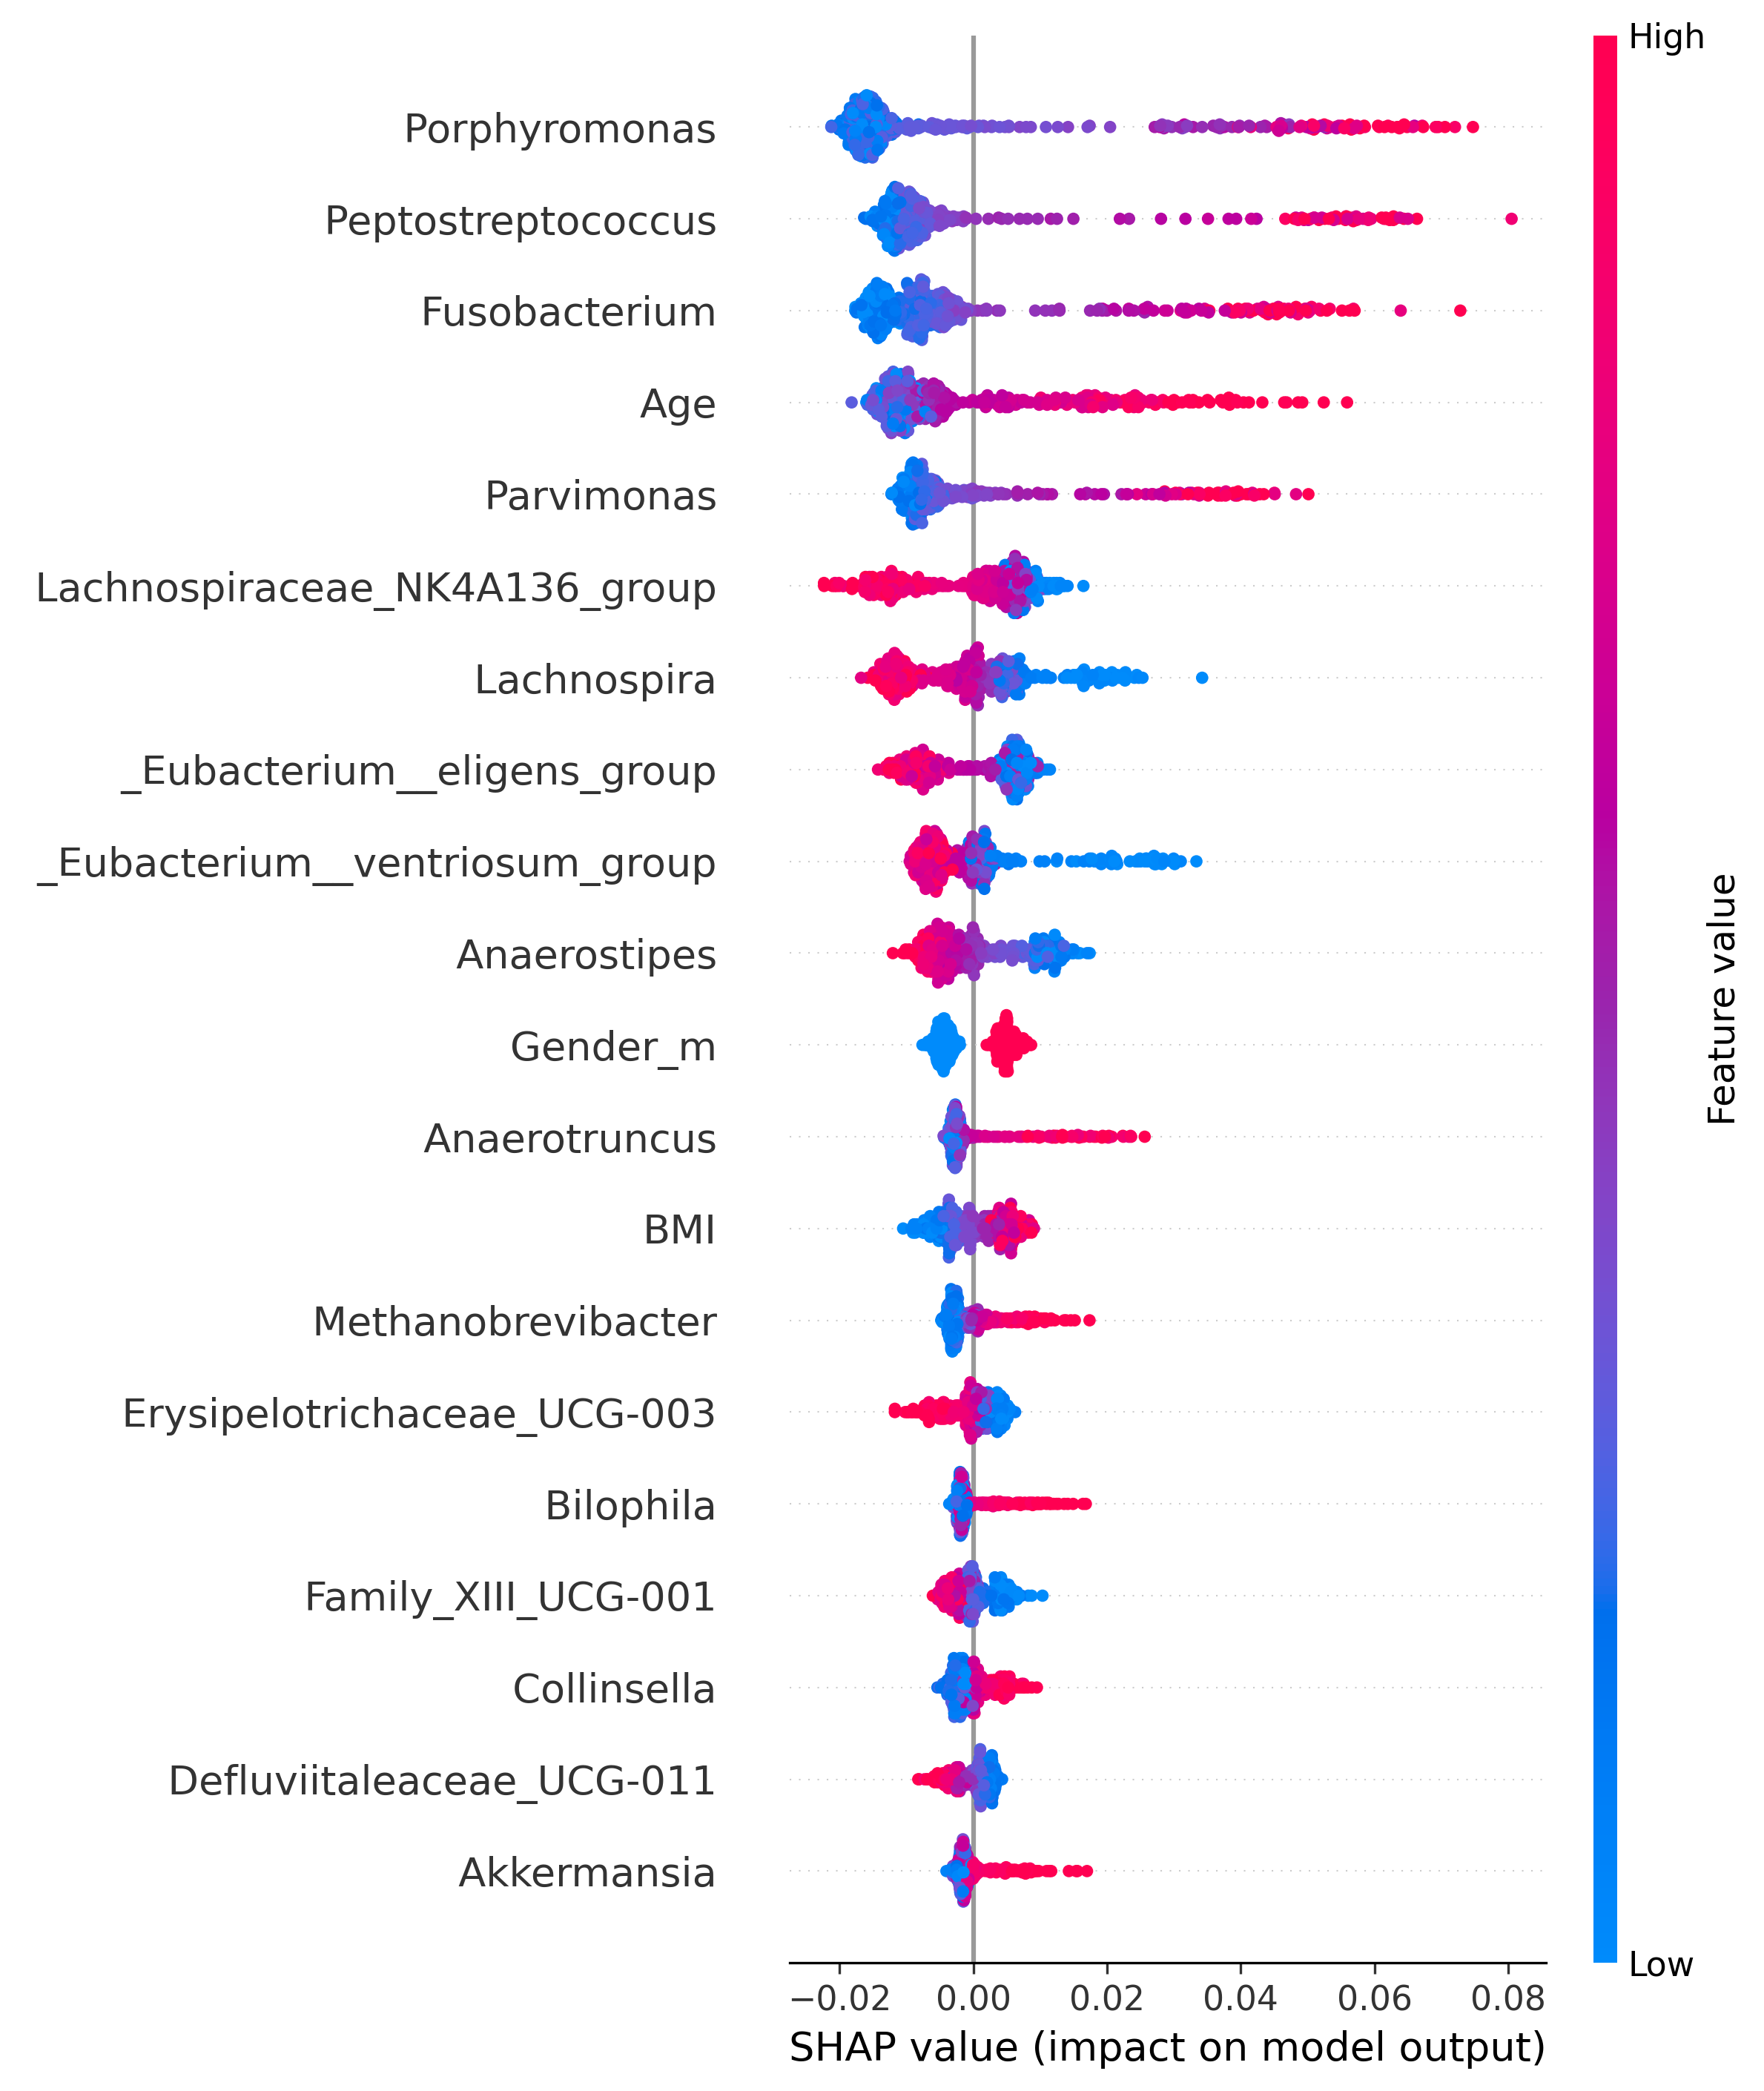

In [10]:
plt.figure(dpi=300)
shap.summary_plot(np.array(average_shap_values), X,max_display=20)

calculus of Jaccard index between rf and SHAP feature importance

In [11]:
rf_feature=np.array(grouped_rf.index[:20])

vals= np.abs(np.array(average_shap_values)).mean(0)

shap_feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
shap_feature_importance=shap_feature_importance.head(20)
shap_feature=shap_feature_importance['col_name'].values

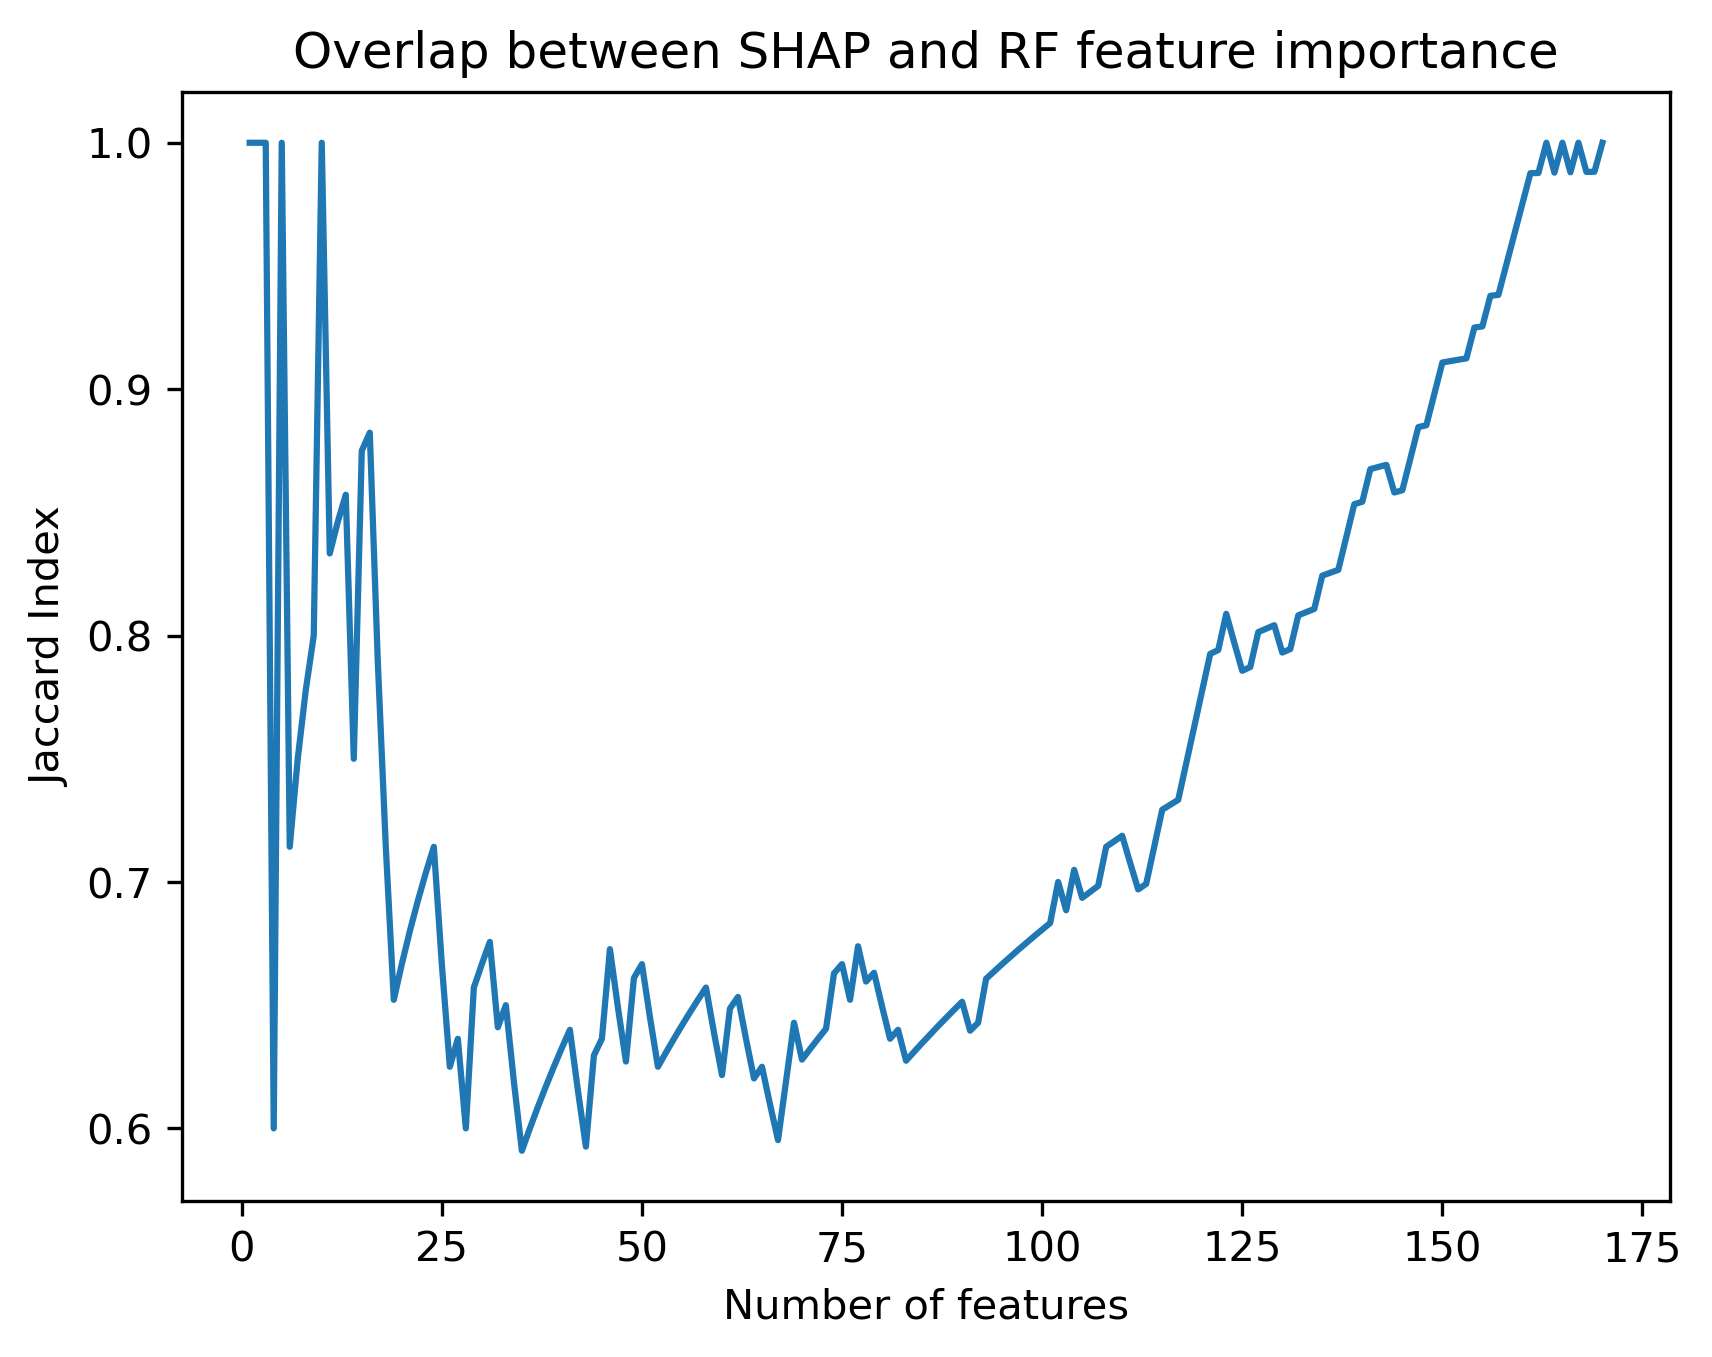

In [12]:
vals= np.abs(np.array(average_shap_values)).mean(0)

   

shap_feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

I_j=[]

for n in range(1,1+len(X.columns)):
    
    S=shap_feature_importance.head(n)
    S=S['col_name'].values
    RF=np.array(grouped_rf.index[:n])
    
    intersect_len=len(set(S).intersection(set(RF)))
    union_len=len(set(S).union(set(RF)))
    
    I_j.append(intersect_len/union_len)

plt.figure(dpi=300)
plt.xlabel('Number of features')
plt.ylabel('Jaccard Index')
plt.title('Overlap between SHAP and RF feature importance')
#plt.xlim((5,200))
plt.plot(list(range(1,1+len(X.columns))),I_j)

In [13]:
intersect_len=len(set(shap_feature).intersection(set(rf_feature)))
union_len=len(set(shap_feature).union(set(rf_feature)))
print('intersection len: ',intersect_len,', union len: ', union_len)
print('Jaccard Index: ', np.round(intersect_len/union_len,2))

intersection len:  16 , union len:  24
Jaccard Index:  0.67


In [14]:
c=0
for i in X.columns:
    print(i, ' Indice:', c)
    c=c+1

 Fusobacterium  Indice: 0
 Bacteroides  Indice: 1
 Prevotella  Indice: 2
 Sphingomonas  Indice: 3
 Blautia  Indice: 4
 Faecalibacterium  Indice: 5
 _Eubacterium__coprostanoligenes_group  Indice: 6
 Akkermansia  Indice: 7
 Lachnoclostridium  Indice: 8
 Escherichia-Shigella  Indice: 9
 Streptococcus  Indice: 10
 UCG-002  Indice: 11
 Paracoccus  Indice: 12
 Agathobacter  Indice: 13
 Methanobrevibacter  Indice: 14
 Subdoligranulum  Indice: 15
 Acidaminococcus  Indice: 16
 Alistipes  Indice: 17
 CAG-352  Indice: 18
 Anaerostipes  Indice: 19
 Enterococcus  Indice: 20
 _Ruminococcus__gnavus_group  Indice: 21
 Christensenellaceae_R-7_group  Indice: 22
 Desulfovibrio  Indice: 23
 _Ruminococcus__torques_group  Indice: 24
 _Ruminococcus__gauvreauii_group  Indice: 25
 Clostridia_UCG-014  Indice: 26
 Porphyromonas  Indice: 27
 Fusicatenibacter  Indice: 28
 Roseburia  Indice: 29
 Parabacteroides  Indice: 30
 Erysipelotrichaceae_UCG-003  Indice: 31
 Veillonella  Indice: 32
 Coprococcus  Indice: 33
 P

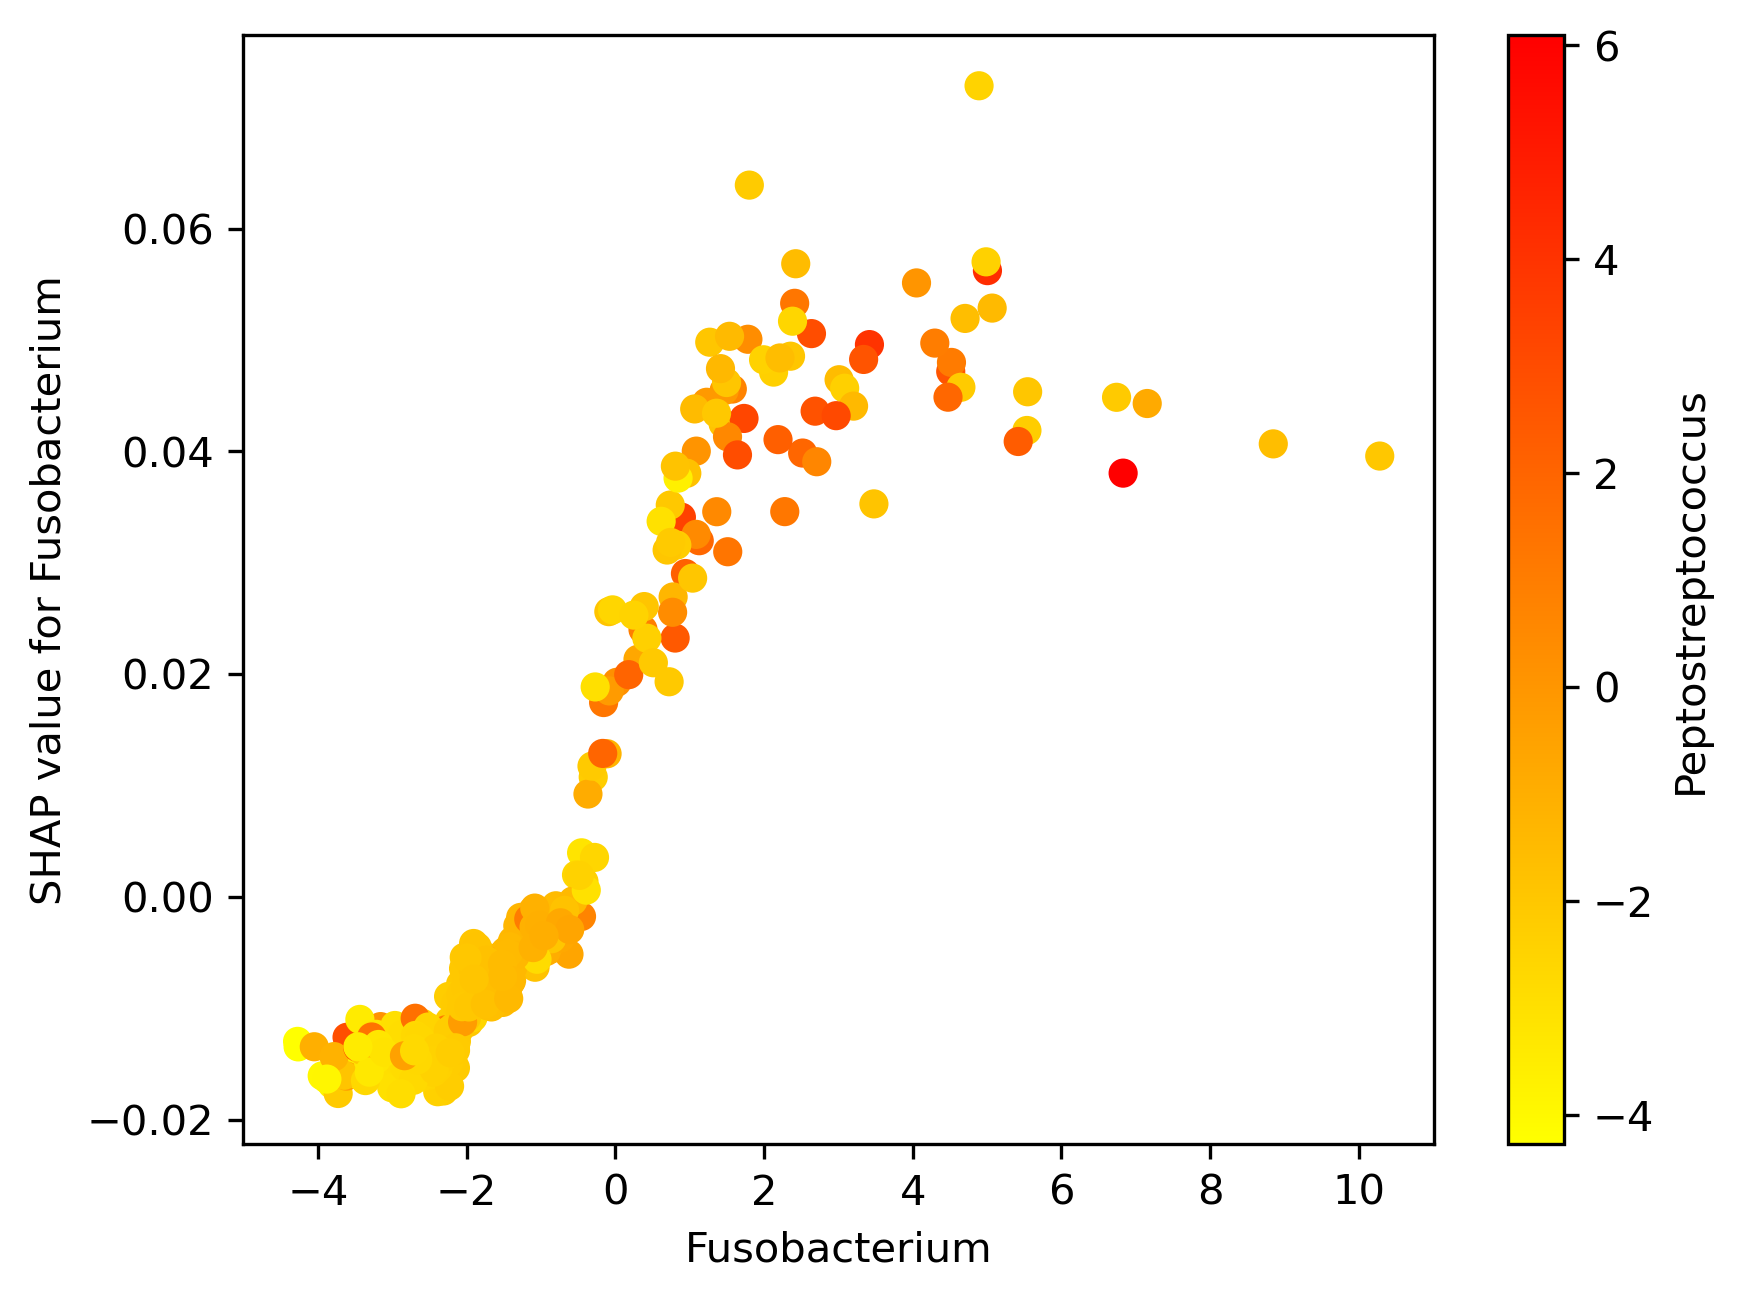

In [15]:
plt.figure(dpi=300)
plt.scatter(X[' Fusobacterium'].values ,np.array(average_shap_values)[:,0], c=X[' Peptostreptococcus'],cmap='autumn_r')
plt.xlabel('Fusobacterium')
plt.ylabel('SHAP value for Fusobacterium')
#plt.title('mean O3 dependance plot')
cbar=plt.colorbar()
cbar.set_label('Peptostreptococcus')

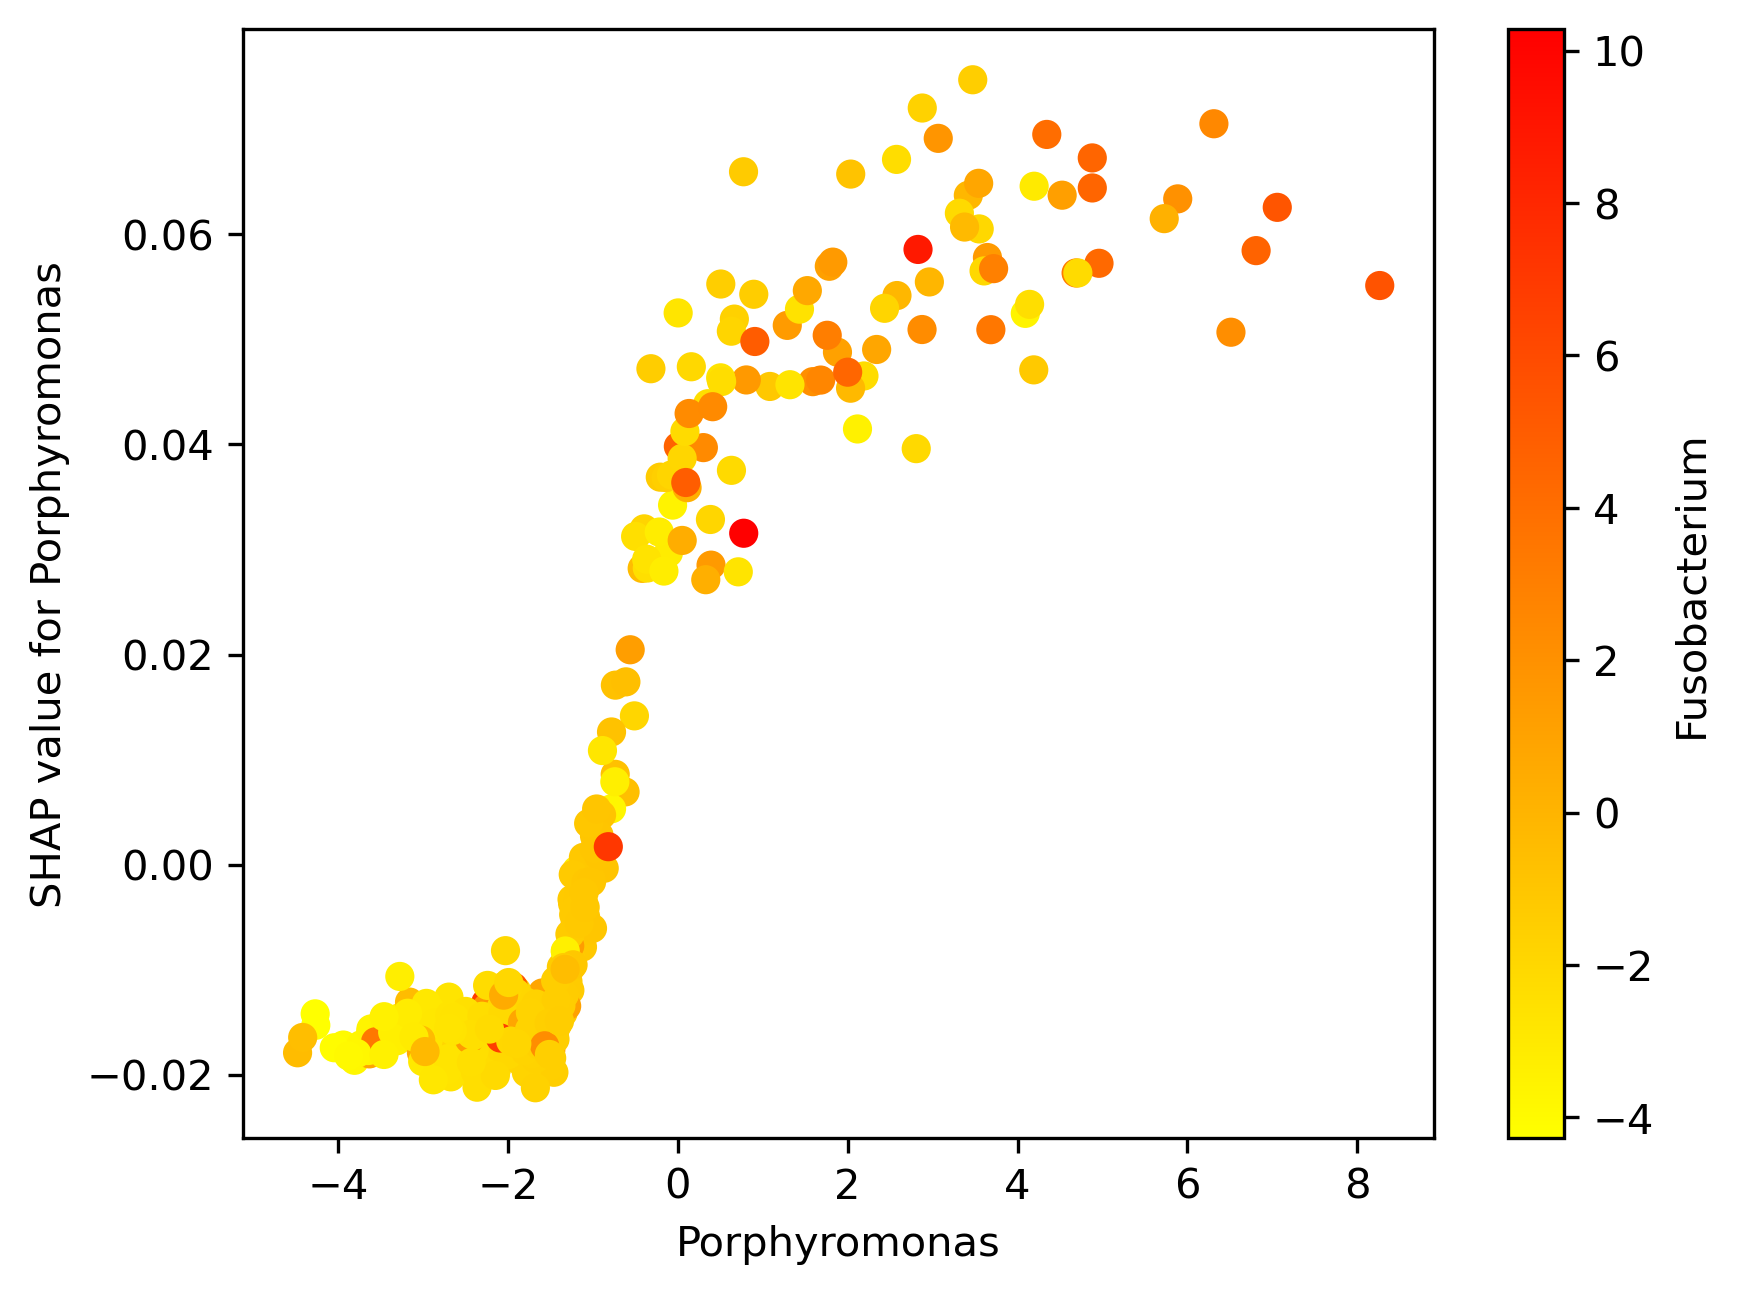

In [16]:
plt.figure(dpi=300)
plt.scatter(X[' Porphyromonas'].values ,np.array(average_shap_values)[:,27], c=X[' Fusobacterium'],cmap='autumn_r')
plt.xlabel('Porphyromonas')
plt.ylabel('SHAP value for Porphyromonas')
#plt.title('mean O3 dependance plot')
cbar=plt.colorbar()
cbar.set_label('Fusobacterium')

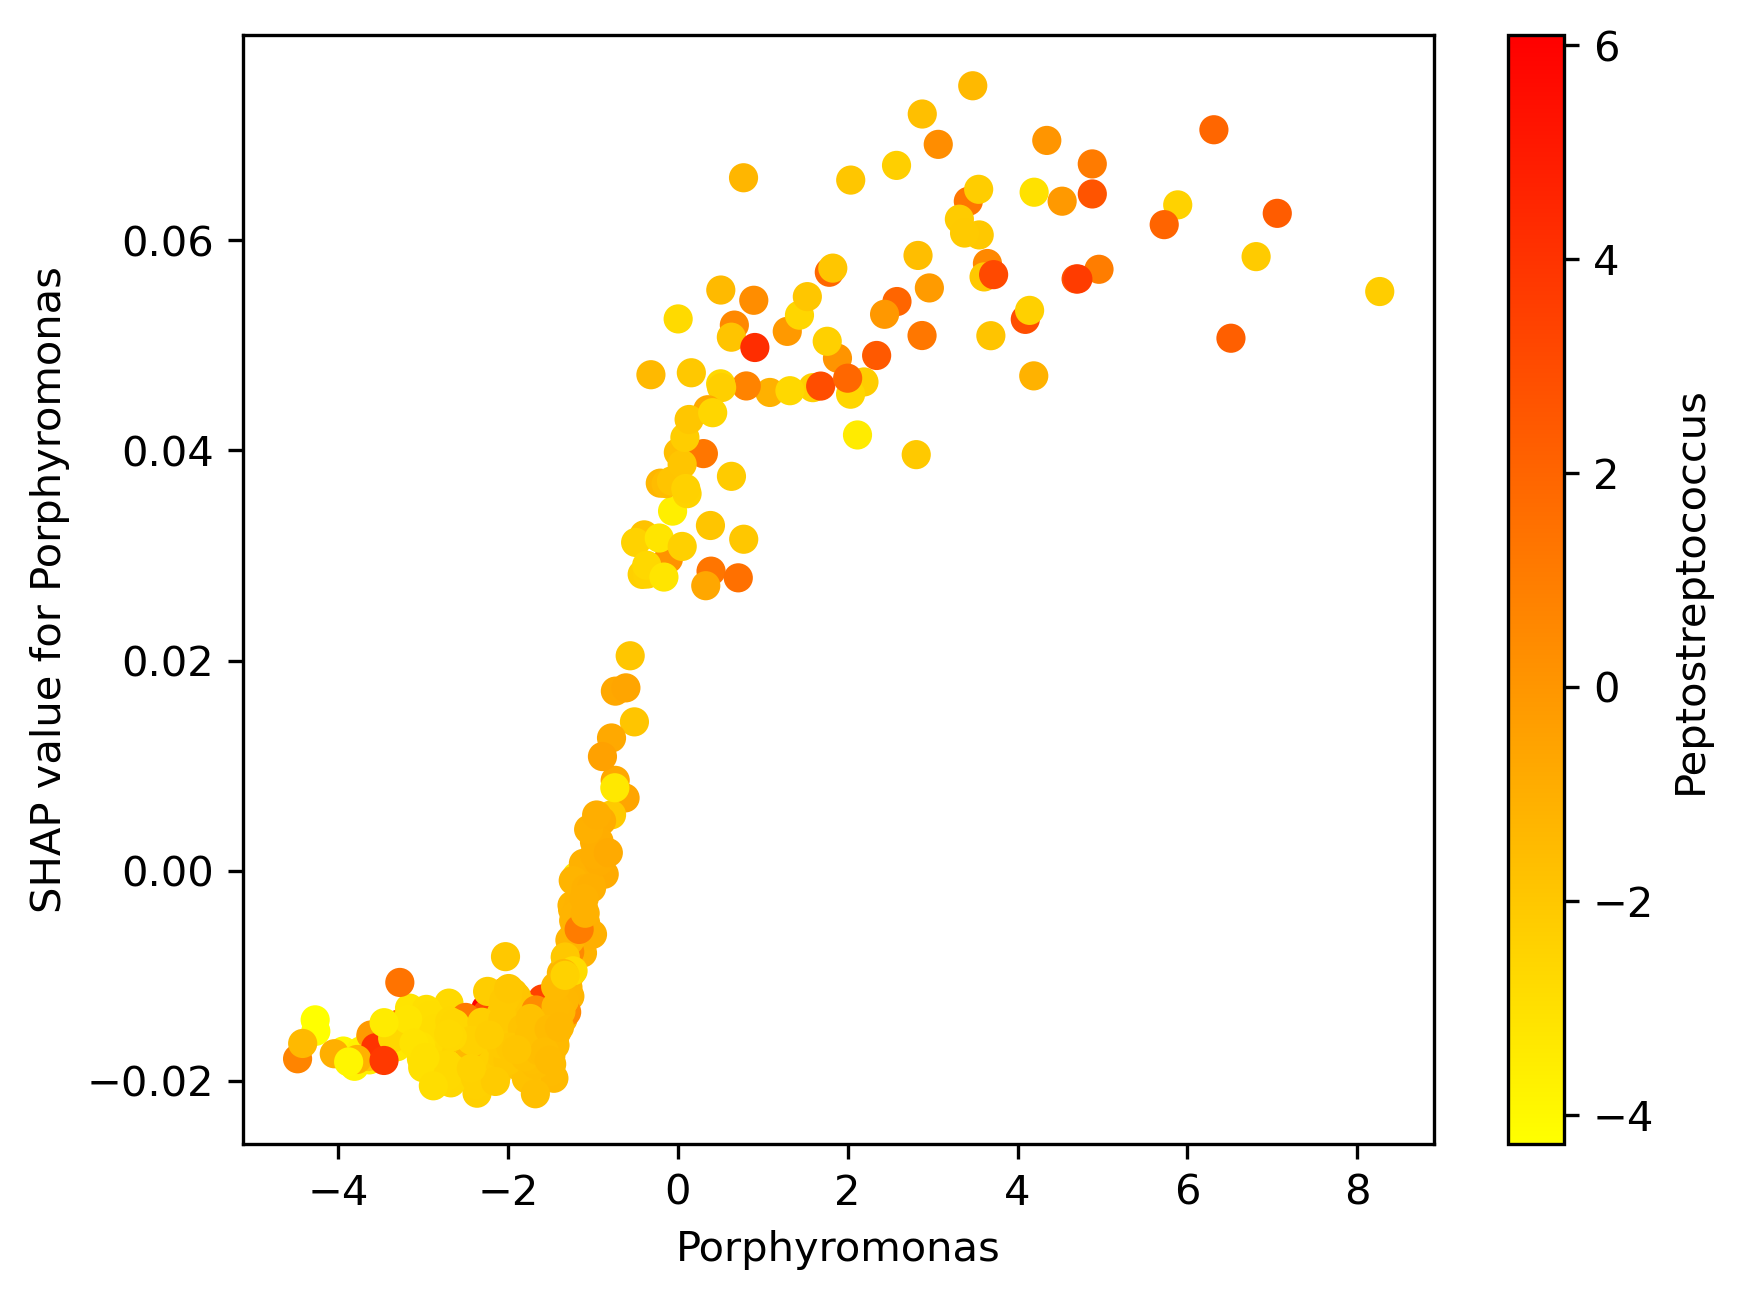

In [17]:
plt.figure(dpi=300)
plt.scatter(X[' Porphyromonas'].values ,np.array(average_shap_values)[:,27], c=X[' Peptostreptococcus'],cmap='autumn_r')
plt.xlabel('Porphyromonas')
plt.ylabel('SHAP value for Porphyromonas')
#plt.title('mean O3 dependance plot')
cbar=plt.colorbar()
cbar.set_label('Peptostreptococcus')